# Image Captioning using CNNs & LSTMs

## Setup notebook


In [18]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models import EncoderDecoderModel
from vocabulary import CocoCaptionsVocabulary
from utils import train, test


In [3]:
spacy.prefer_gpu()
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## COCO Dataset


### Download & extract the dataset


In [4]:
DATASET_DIR = Path("./datasets/coco")
MODEL_DIR = Path("./checkpoints/coco")
RESULTS_DIR = Path("./results/coco")

DATASET_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
DATASET_URLS = [
    "http://images.cocodataset.org/zips/train2014.zip",
    "http://images.cocodataset.org/zips/val2014.zip",
    "http://images.cocodataset.org/zips/test2014.zip",
    "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
]

for url in DATASET_URLS:
    name, stem = Path(url).name, Path(url).stem
    if (DATASET_DIR / stem).exists():
        continue

    !wget -P {DATASET_DIR} {url}
    !tar -xf {DATASET_DIR / name} --directory {DATASET_DIR}


In [7]:
BATCH_SIZE = 32
EPOCHS = 1
HIDDEN_SIZE = 512
EMBED_SIZE = 512


### Setup training and testing datasets

* We will normalize the data using the mean and stddev of the ImageNet dataset


In [8]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     (0.485, 0.456, 0.406),
        #     (0.229, 0.224, 0.225),
        # ),
    ]
)

train_dataset = datasets.CocoCaptions(
    root=DATASET_DIR / "train2014",
    annFile=DATASET_DIR / "annotations_trainval2014/captions_train2014.json",
    transform=transform
)

valid_dataset = datasets.CocoCaptions(
    root=DATASET_DIR / "val2014",
    annFile=DATASET_DIR / "annotations_trainval2014/captions_val2014.json",
    transform=transform
)

# # ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


### Visualize dataset


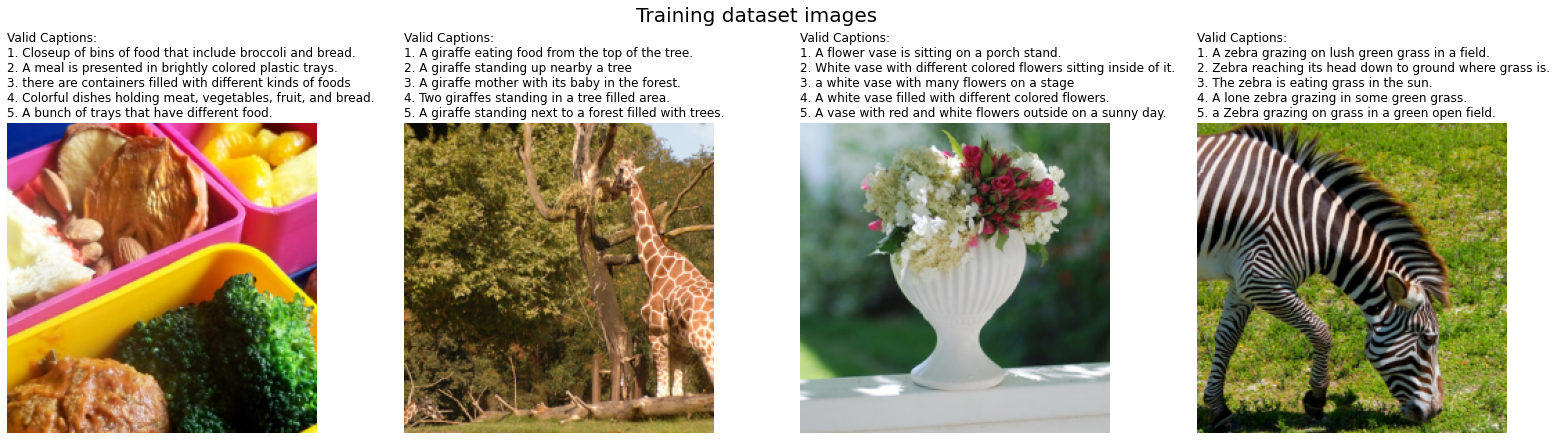

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6), constrained_layout=True)
fig.suptitle("Training dataset images", fontsize=20)

for i, ax in enumerate(axes):
    img, captions = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")

    captions = [(f"{idx + 1}. " + c) for idx, c in enumerate(captions)]
    captions = ["Valid Captions:"] + captions
    captions = "\n".join(captions)
    ax.set_title(captions, ha="left", x=0)

fig.savefig(RESULTS_DIR / "train_dataset.png")


### Build vocabulary from captions


In [10]:
vocab = CocoCaptionsVocabulary(coco=train_dataset.coco)

print("Saving vocabulary...")
with open(MODEL_DIR / "vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


C:\Python39\lib\site-packages\spacy\util.py:1639: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 414113/414113 [00:14<00:00, 29401.83it/s]


Selecting words with >= 5 appearances ie 8793 words of 23444 total.
Saving vocabulary...


## Build & Train the Encoder-Decoder Model


In [17]:
model = EncoderDecoderModel(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"]).to(device)

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=MODEL_DIR,
)


hi
hi
